## Loan Granting Project

In [1]:
# Importation of required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import date
from datetime import datetime
pd.set_option("max_columns", 200)
pd.set_option("max_rows", 100)
plt.style.use("ggplot")


# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# To build linear model for statistical analysis and prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

# Warnings
import warnings as ws
ws.filterwarnings('ignore')

In [2]:
## Loading the Borrower and loan tables as dataframes
borrower = pd.read_csv("C:/Users/ESHO/Documents/Data Science Mentorship/Projects/borrower_table.csv")
loan = pd.read_csv("C:/Users/ESHO/Documents/Data Science Mentorship/Projects/loan_table.csv")

In [ ]:
# Checking that shape for the borrowers information
print("Detail of borrowers' dataset:", borrower.shape)

# Checking that shape for the loan information
print("Detail of Loans' dataset:", loan.shape)

* The dataset with borrowers information has 101100 rows and 12 columns
* The dataset with general information on the loan has 101100 rows and 5 columns
* The two datasets have the same number of records, that is 101100 Customers' records

In [3]:
## Merge the Borrower and Loan datasets using loan_id.
credit_data = pd.merge(borrower, loan, how = "left", on = "loan_id")

In [ ]:
#Checking the shape of the dataset
print("Merged tables' details:", credit_data.shape)

* The datasets were merged correctly; 101100 rows and 16 columns as expected

In [ ]:
#Checking for any repeated customers' record in the merged dataset using loan_id
unique_counts = credit_data["loan_id"].nunique()
unique_counts

* There was no repeated customers'records with the same loan_id in the merged dataset

In [ ]:
#Checking the first and the last 10 records in the dataset
credit_data.head(10)

In [ ]:
credit_data.tail(10)

In [ ]:
#Checking data type of the features
credit_data.dtypes

From the features in the dataset, there are:
* 7 are categorical data type
* 7 are interger data type
* 1 is float
* 1 is date type

## Data Preparation

In [ ]:
## Check for missing values in the dataset

# % of missing data
print('{0:48} {1:22} {2:10}' .format("Features", "Number Missing Data", "Percentage"))
for col in credit_data.columns:
    missing_value = credit_data[col].isnull().sum()
    missing_pcent = np.mean(credit_data[col].isnull())
    print('{0:48} {1:10d} {2:17d}' .format(col, missing_value, round(missing_pcent*100)))

### Missing Data
* Out of the 16 features in the dataset, four have missing data.
* 54,947 missing values in fully_repaid_previous_loan and currently_repaying_other_loans due to the customers' first time loan requests
* 53,446 missing values in loan_repaid due to loan request not granted
* 6,972 missing value in average_percentage_credit_card_limit_used_last_year, this may be due to entry error or omission. 

In [ ]:
#Checking the unique values in the columns with missing data to determine the contents of the features
print('Unique values in fully repaid previous loans column:',credit_data.fully_repaid_previous_loans.unique())
print(" ")
print('Unique values in repaid loans column:', credit_data.loan_repaid.unique())
print(" ")
print('Unique values in currently repaying other loans column:', credit_data.currently_repaying_other_loans.unique())
print(" ")
print('Unique values in average % credit limit column:')
print(np.sort( credit_data.avg_percentage_credit_card_limit_used_last_year.unique()))

In [ ]:
# Check for duplicate entries in the dataset
credit_data.loc[credit_data.duplicated(subset=["yearly_salary","date", "loan_purpose",
            "saving_amount", "checking_amount"])] ## 5 features were used to check if two records were in anyway the same

* There were no duplicate records in the merged dataset

In [4]:
## Remane some columns to make them tidy
credit_data.rename(columns={'fully_repaid_previous_loans':'FRP_Loans', 'currently_repaying_other_loans': 'CRO_Loans',
                            'total_credit_card_limit':'TCC_Limit','avg_percentage_credit_card_limit_used_last_year':"Avg_CCL"},
                               inplace=True)

## Keys for renamed columns
* Fully_repaid_previous_loans: FRP_Loans
* Currently_repaying_other_loans: CRO_Loans
* Total_credit_card_limit: TCC_Limit
* Avg_percentage_credit_card_limit_used_last_year: Avg_CCL

In [5]:
## Missing Data Treatment
## Missing values replacement in credit_data2 dataset
credit_data["FRP_Loans"].replace(np.nan, 2, inplace=True) #2 for NA representing Customer is borrowing for the first time
credit_data["loan_repaid"].replace(np.nan,2, inplace=True) #2 for NA representing loan request was not granted  
credit_data["CRO_Loans"].replace(np.nan, 2, inplace=True)  #2 for NA representing the loan is the first loan

# Drop the observations whose average percentage credit card limits were missing, reset index, and drop index column
credit_data = credit_data.dropna(axis=0).reset_index(drop=True)

In [6]:
## Format the date column
credit_data['date'] = pd.to_datetime(credit_data['date'], format='%Y-%m-%d')

In [7]:
## Converting the data type of categorical features to 'category'
cat_cols = ["is_first_loan", "FRP_Loans", "CRO_Loans", "is_employed", "loan_purpose", "loan_granted", "loan_repaid"]
credit_data[cat_cols] = credit_data[cat_cols].astype('category')

In [8]:
## Feature Extraction
### Function to extract details from loan request Date
d = []
m = []
wd = []
        
def loan_request_date(date):
    for dates in date:
        day = round(datetime.date(dates).day)
        d.append(day)
        month = dates.month
        m.append(month)
        weekday = dates.weekday()
        wd.append(weekday)
    
    credit_data["day"] = pd.DataFrame(d)
    credit_data["month"] = pd.DataFrame(m)
    credit_data["weekday"] = pd.DataFrame(wd)
      
    return credit_data       

In [9]:
#Extracting useful details from the date column 
loan_request_date(credit_data["date"])

,loan_id,is_first_loan,FRP_Loans,CRO_Loans,TCC_Limit,Avg_CCL,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose,date,loan_granted,loan_repaid,day,month,weekday
0,289774,1,2.0,2.0,8000,0.49,3285,1073,0,0,47,3,business,2012-01-31,0,2.0,31,1,1
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1,investment,2012-11-02,0,2.0,2,11,4
2,135565,1,2.0,2.0,6900,0.82,2085,3422,1,24500,38,8,other,2012-07-16,1,1.0,16,7,0
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1,investment,2012-06-05,0,2.0,5,6,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1,emergency_funds,2012-11-28,0,2.0,28,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94123,38238,1,2.0,2.0,2200,0.83,1295,2240,0,0,47,2,other,2012-12-24,0,2.0,24,12,0
94124,590712,1,2.0,2.0,3800,0.70,340,3802,1,36100,41,7,business,2012-05-17,1,1.0,17,5,3
94125,961276,1,2.0,2.0,1600,1.06,445,1757,1,40800,71,3,other,2012-09-07,0,2.0,7,9,4
94126,551027,0,1.0,0.0,7000,0.82,354,1435,1,41900,44,2,investment,2012-08-23,1,0.0,23,8,3


### Exploratory Data Analysis

In [ ]:
#Summary statistics for the 8 numerical columns
credit_data.describe().T

* Total credit card limit (tcc_limit): The average credit card limit for customers is well above 4300 (median) which is max
    limit for half of the bank's customers. 75% of the customers have monthly credit card limits below 5700 and the gap
    between the meam and the median showed that the variable is skewed and suggested the presence of some outliers
* Average percentage credit card limit used last year(avg_ccl): The average credit card limit used last was 72%, while the max
    was 109%
* Savings amount: Customers'savings account balance ranges between 0 and 10641 with customers average balance of about 1837.53
    when the balances of 50% of the customers are below 1,369 that shows an evidence of some outliers in the dataset
* Checking Amount: Customers'current account balances are between zero and 13906 with the average balance of 3235.06
    The balances of 50% of the customers are below 2725, also the huge difference between the balances of 75% of the
    customers and the maximum balance indicated that there were outliers in the dataset.
* Yearly salary: The average salary earned annually by the customers is 21503.15 Customers salary range is between 0 and
    97200 indicating that some customers are either retired or not employed. There are outliers going by the distribution of
    the dataset.
* Age: The average age of the bank customers is 41years.The youngest customers are 18year and oldest are 79year. Most customers
    are below 50years old.
* Dependent Number: The average household size is about 4 with the maximum number of dependants as 8

In [ ]:
#Summary of the Categorical columns of the data set    
cat_cols = ["is_first_loan", "FRP_Loans", "CRO_Loans", "is_employed", "loan_purpose", "loan_granted", "loan_repaid"]

for i in cat_cols:
    print('Unique values in',i, 'are :')
    print(credit_data[i].value_counts().sort_index())
    print()
    print(credit_data[i].value_counts(1).sort_index() * 100)
    print('*'*50)

* First Loan: Most of the customers in the dataset (51,121) are  applying for loans for the first time
* Fully repaid previous loans: Most of the customers who had old loans fully repaid on time only 4291 defaulted
* Currently repaying other loans: Only 15,170 customers are currently repaying other loans
* Employment Status: Two quarter of the customers are employed
* Loan Purpose: Most loan requests were home loans, followed by Business and investment
* Loan Granted: Most customers loan requests were denied. Only 49.7 percent of requests were granted.
* Loan Repayment: About 65 percent of the customers who were offered loans repaid their loan.
* Loan requests submission are mostly done between mondays and thursdays

## Univariate Analysis

### Univariate analysis of numerical variables

In [ ]:
# This function takes the numerical column as the input and returns the boxplots and histograms for the variable.

def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,color = 'orange')\
    if bins else sns.distplot(feature, kde=False, ax=ax_hist2,color='tab:cyan') # For histogram
    ax_hist2.axvline(np.mean(feature), color='purple', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

### Analysis of Savings Account Balances

In [ ]:
histogram_boxplot(credit_data['saving_amount'])

* The distribution of saving amount is positively skewed and boxplot indicates a huge presence of outliers in the variable
* The median and mean of the saving amount are different
* 50% of the customers saving account balances were below 1400

### Analysis of Checking Account Balances

In [ ]:
histogram_boxplot(credit_data["checking_amount"])

* The distribution of the customers checking account balance as at the point of loan request is positively skewed and the
    boxplot indicates a huge presence outliers
* The median is lower than the mean, showing that the distribution is skewed and the confirmation that there are outliers in
    the variable
* 50% of the customers have less than 3000 balance in their current account

### Analysis of Total Credit Card Limit

In [ ]:
histogram_boxplot(credit_data["TCC_Limit"])

* The distribution of the customers credit card limit is somewhat symmetrical but boxplot indicated presence of outliers
* The median and mean of limit are within the same range of 4300 confirming the symmetrical distribution of the variable
* Most customers' monthly credit card limits are below 8000 

### Analysis of Yearly Salary

In [ ]:
histogram_boxplot(credit_data["yearly_salary"])

* The distribution of the customers yearly salary is somewhat symmetrical but boxplot indicates presence of few outliers
* Customers median and mean of the customers yearly salary are within the same range of 21,500
* About 33,000 customers are not currently employed or earning any income

### Analysis of Customers Age

In [ ]:
histogram_boxplot(credit_data["age"]) 

* The distribution of the customers age is somewhat symmetrical but boxplot indicates some outliers
* The median and mean of the customers' age are within the same range of 41, showing that 50% of the customers are below 41 years
* The age range of the customers is between 18 and 79 years 

### Analysis of Dependent Number

In [ ]:
histogram_boxplot(credit_data["dependent_number"])

* The distribution of the customers dependants number is somewhat normally distributed and boxplot indicated no outliers
* The number of dependants are between 0 and 8 members for the customers.

### Analysis of Average Percentage of Credit Card Use Limit

In [ ]:
histogram_boxplot(credit_data["Avg_CCL"])

* The distribution of the customers average credit card limit used last year(%) is negatively skewed and boxplot indicated
    the presence of outliers
* The median and mean of customers average per credit card use limit are within 73%
* 50% of the customers used below 74% of their credit card use limit 

### Univariate Analysis of Categorical Variables

In [ ]:
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(z):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''

    total = len(credit_data[z]) # length of the column
    plt.figure(figsize=(15,5))
    ax = sns.countplot(credit_data[z],palette='Paired')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

### Analysis of Is First Loan

In [ ]:
perc_on_bar("is_first_loan")

* About 54.3% of the customers in the dataset are applying for loans for the first time

### Analysis of fully repaid previous Loan

In [ ]:
credit_data.info()

In [ ]:
perc_on_bar("FRP_Loans")

* 54.3% of the Customers are request for loan for the first time
* 41.1% had previous loans and made full repayment
* Only 4.6% of the customers had previous loans but did not repay

### Analysis of Currently repaying other loans

In [ ]:
perc_on_bar("CRO_Loans")

* About 16% of the customers have other loans they are currently repaying
* 29.6% are not repaying any loans while about 54% are first time customers

### Analysis of Customer Employment Status

In [ ]:
perc_on_bar("is_employed")

* About 67% of the customers are employed

### Analysis of Loan Purpose

In [ ]:
perc_on_bar("loan_purpose")

* Most loan requests were home loan while the least requests were for other purposes.
* About 22% of the loan requests were for business and 21.4% for investment

### Analysis of Loan Granted

In [ ]:
perc_on_bar("loan_granted")

* 50.3% of loan applications were denied, only 49.7% requests was granted

### Analysis of Loan Repaid

In [ ]:
perc_on_bar("loan_repaid")

* About two third of the total requests granted were paid back

### Analysis of Loan Request Day

In [ ]:
perc_on_bar("day")

* There is no particular day(s) which can be associated with loan applications. That is application were submitted
    as the customers were ready.

### Analysis of Loan Request Month

In [ ]:
perc_on_bar("month")

* There are no particular month(s) which can be associated with loan applications. That is application were submitted
    as the customers deemed it fit. No promotions or enticement for customers to apply within the period of review.

### Analysis of loan Request (days of the week)

In [ ]:
perc_on_bar("weekday")

* Loan applications submission seems to be day of the week dependent. Monday to Wednesday showed to be days when most applications are submitted and Friday being the end of the week day showed less submissions.

## Bivariate Analysis

In [158]:
#Making loan_granted a numeric variable
credit_data1 = credit_data.copy()
col = ["loan_granted"]
credit_data1[col] = credit_data1[col].astype(int)

In [ ]:
#Correlation Matrix for Numeric Variables with Loan Granted (a Categorical Variable) to determine the relationship between 
#each numeric variable and Loan granted
plt.figure(figsize=(15,7))
sns.heatmap(credit_data1.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')
plt.show()

* Loan_granted has positive although insignificant relationship with TCC_limit(0.1), saving_amount(0.14), checking_amount(0.14)
  and a more significant relatonship with yearly_salary(0.42). It relationship with Avg_CCL is negative and insignificant.

* The relationships of other numeric variables among themselves are quite insignificant

In [ ]:
#Subset the Credit_data dataframe for customers whose loan requests were granted
credit_data2 = credit_data[credit_data["loan_granted"]!=0].reset_index(drop=True)

#Making loan_repaid a numeric variable
cat_cols = ["loan_repaid"]
credit_data2[cat_cols] = credit_data2[cat_cols].astype(int)

In [ ]:
#Correlation Matrix for Numeric Variables with loan repaid (a Categorical Variable) to determine the relationship between
#each numeric variable and Loan repaid (target variable)
plt.figure(figsize=(15,7))
sns.heatmap(credit_data2.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')
plt.show()

* Loan_repaid has a more significant positive relationship with TCC_limit(0.38), saving_amount(0.49), checking_amount(0.49),
  yearly_salary(0.42). It relationships with Avg_CCL and dependent_number are negative (-0.21 & -0.14) respectively but
  insignificant.

* The relationships of other numeric variables among themselves are quite insignificant

In [ ]:
### Bivariate Analysis of categorical variables and loan granted (protarget variable)
def stacked_plot(x):
    sns.set()
    ## crosstab
    tab1 = pd.crosstab(x,credit_data['loan_granted'], margins = True)
    print(tab1)
    print('-'*120)
    
    ## crosstab 2
    tab2 = pd.crosstab(x, credit_data['loan_granted'], margins = True, normalize = "all")
    print(tab2 * 100)
    print('-' * 120)

    ## crosstab 3
    tab3 = pd.crosstab(x,credit_data['loan_granted'],margins=True, normalize='index')
    print(tab3 *100)
    print('-'*120)

    ## visualising the cross tab
    tab = pd.crosstab(x,credit_data['loan_granted'],normalize='index').sort_values(by=1,ascending=False)
    tab.plot(kind='bar', stacked=True, figsize=(10,4))
    plt.legend(loc='lower left', frameon=False,)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()

In [ ]:
stacked_plot(credit_data["is_first_loan"])

* 49.5% of the requests of the first time customers were granted while even for old customers' only 49.8% of their requests were granted. Overall, 54.1% of the loan requests granted were for first time applicants, while only 45.9% were for old customers

In [ ]:
stacked_plot(credit_data["CRO_Loans"])

* 16.12% were currently repaying other loans out of which 6.7% were granted new loan. 83.88% were not repaying any loan but only 42.98% were granted their request

In [ ]:
stacked_plot(credit_data["is_employed"])

* 68.1% of the employed customers’ requests were granted while 12.4% of the unemployed customers' request were only granted. On the overall, 45.6% and 4.1% of applications granted were from employed and unemployed customers respectively and 21.4% and 29% of applications denied were from employed unemployed customers respectively.

In [ ]:
stacked_plot(credit_data["loan_purpose"])

* 11.2% of the loans granted were for business, 11.1% for investment, 12.1% for home, 8% for emergency funds, and 7.2%
    for other purposes.
* 51.8% of business loans request were granted, 51.8% of investment, 50.2% of home, 45.6% of emergency funds,
    and 44.6% of other purposes.

In [ ]:
stacked_plot(credit_data["loan_repaid"])

* 30550 out of 46751 customers given loans were repaid.

In [ ]:
stacked_plot(credit_data["FRP_Loans"])

* 20.57% of the customers granted new loan had previous loans and paid it back while 2.2% had previous loans but did not repay
* 20.56% of the customers had previous loans, repaid but were not granted new loans
* 48.3% of the requests of customers who had previous loans and did not pay back were successful, 2072 out of 4291
* 50% of the requests of customers who had previous loans and paid back were successful, 19366 out of 38,716

In [ ]:
### Bivariate Analysis of categorical variables and loan repaid (main target variable)
def stacked_plt(y):
    sns.set()
    ## crosstab
    tab1 = pd.crosstab(y,credit_data['loan_repaid'], margins = True)
    print(tab1)
    print('-'*120)
    
    ## crosstab 2
    tab2 = pd.crosstab(y, credit_data['loan_repaid'], margins = True, normalize = "all")
    print(tab2 * 100)
    print('-' * 120)

    ## crosstab 3
    tab3 = pd.crosstab(y,credit_data['loan_repaid'],margins=True, normalize='index')
    print(tab3 *100)
    print('-'*120)
    
    ## crosstab 4
    tab4 = pd.crosstab(y,credit_data['loan_repaid'],margins=True, normalize='columns')
    print(tab4 *100)
    print('-'*120)

## visualising the cross tab
    tab = pd.crosstab(y,credit_data['loan_repaid'],normalize='index').sort_values(by=1,ascending=False)
    tab.plot(kind='bar',stacked=True,figsize=(17,7))
    plt.legend(loc='lower left', frameon=False,)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()

In [ ]:
stacked_plt(credit_data["is_first_loan"])

* •	14.7% of the customers had previous loans, had their new requests granted and repaid the new loan while 17.7% had no previous loans, had their requests granted and also repaid their loan
* 50.2% of the applications of customers who had previous loans were denied, 32.3% were successful and they repaid, and 
    17.6 were granted but refused to repay.
* 50.5% of the applications of customers who were first time applicants were denied, 32.6% were successful and they repaid,
    and 16.9% were granted but refused to repay.
* Out of the 43007 customers who had had previous loans, 21569 were denied new loan, 13876 were granted and repaid, and 7562
    were also granted but did not repay.
* Out of the 51121 customers who were first loan applicants, 25808 were denied new loan, 16674 were granted and repaid, 
    and 8639 were also granted but did not repay.

In [ ]:
stacked_plt(credit_data["FRP_Loans"])

* Out of the 32.5% that made repayment of the new loans, 13.45% were those that fully repaid their previous loans, 1.3% were those that defaulted, and 17.7% were first time loan customers.
* Out of the 17.2% of all the customers did not repay their loans. 0.9% were defaulter that did not fully repay their previous loans, 7.1% fully repaid their previous loan, and 9.2% were first time loan customers.

In [ ]:
stacked_plt(credit_data["CRO_Loans"])

* Out of the 32.5% customers that repaid the new loan. 12.9% were not currently repaying any loans, 1.9% were currently repaying loans and 17.7% were customers with no previous loans.
* 3.2% of the customers had no loan running but still defaulter and 4.8% had current loan running.
* Most defaults were from customers who were first loan customers
* Most of the customers that were given new loan while they were repaying another loans defaulted.

In [ ]:
stacked_plt(credit_data["is_employed"])

* 87.6% of customers who were unemployed where denied the new loan and out of the 12% that were given loan about 10% defaulted.
* Out of the 66.9% of the employed customers 21.4% were denied loan, 31.7% repaid but 13.9% defaulted.

In [ ]:
stacked_plt(credit_data["loan_purpose"])

* Most default originated from loans requested for emergency funds, followed by home loans. The least default was from loan secured for business.
* Most repayment were from business loans, followed by home loans with emergency funds being the least.

### Outlier treatment
* Most of the numeric variables had outliers which in theory should be treated but in practice these situations were possible so outlier treatment will be limited to the features age and it was due to default rate of unemployed customers. Since the maximum age of the customer was 79, for the purpose of the project 65 years would be the benchmark age for anyone who was not earning income above 10,000.

In [159]:
## Droping features that are not useful for modeling
cols = ["day","month","weekday","loan_id", "date"]
credit_data1.drop(columns = cols, axis=1, inplace=True)

## New dataframe for customers who are less than 71 and those who are above 70 with yearly income of at least $10,000
credit_data3 = (credit_data1[~((credit_data1["age"] > 65) & (credit_data1["yearly_salary"] <= 10000))]).reset_index(drop=True)

### Features Engineering 

In [160]:
## Converting some features to categorical data type
cols = ["FRP_Loans","CRO_Loans", "loan_repaid", "loan_granted"]
credit_data3[cols] = credit_data3[cols].astype(int).astype('category')

In [161]:
# One Hot Encoding of the categorical features using get_dummies in preparation for modeling
cols = ["FRP_Loans","CRO_Loans","loan_purpose"]
credit_data3 = pd.get_dummies(credit_data3, columns=cols)

In [162]:
## Transformation of the numeric features using MinMaxScalar
cols = ["TCC_Limit", "Avg_CCL", "saving_amount", "checking_amount", "yearly_salary", "age", "dependent_number"]
credit_data3[cols] = MinMaxScaler().fit_transform(credit_data3[cols])

In [163]:
# Clean dataset ready for modeling
credit_data3

# Creating a copy of the cleaned dataset to model for loan_repaid
credit_data4 = credit_data3.copy()

## Modeling

* Modeling for this project is divided into two aspect, the first is to model the loan granting feature, in order to improve
* the process. The initial loan_granted feature was replaced by the predicted loan granted feature to model the loan repaid feature.

In [164]:
## Separating Target feature from the other independent features
cols = ["loan_granted", "loan_repaid"]
y = credit_data3["loan_granted"]
x = credit_data3.drop(cols, axis=1)

In [165]:
## Identifying important features in the dataset using Random forest
modelRF = RandomForestClassifier()
modelRF.fit(x, y)

FImportance = pd.DataFrame(modelRF.feature_importances_, x.columns).reset_index()
FImportance.columns =['feature', 'measure']
FImportance= FImportance.sort_values('measure', ascending=False)
FImportance

,feature,measure
6,yearly_salary,0.218622
2,Avg_CCL,0.138026
5,is_employed,0.128454
3,saving_amount,0.120004
4,checking_amount,0.118978
1,TCC_Limit,0.095591
7,age,0.090243
8,dependent_number,0.043555
17,loan_purpose_home,0.006348
15,loan_purpose_business,0.006276


In [166]:
## Checking Multicollinerity using Variance inflation factor computation
ind_features = x.copy()
ind_features = add_constant(ind_features).astype(float)

vif = pd.Series([variance_inflation_factor(ind_features.values,i) for i in range(ind_features.shape[1])],
                       index=ind_features.columns, dtype = float)
print('Features Variance inflation factor: \n\n{}\n'.format(vif))

Features Variance inflation factor: 

const                           0.000000e+00
is_first_loan                            inf
TCC_Limit                       1.109852e+00
Avg_CCL                         1.031188e+00
saving_amount                   1.191399e+00
checking_amount                 1.188970e+00
is_employed                     2.698541e+00
yearly_salary                   2.810135e+00
age                             1.002623e+00
dependent_number                1.012842e+00
FRP_Loans_0                     2.642647e+11
FRP_Loans_1                     5.826275e+04
FRP_Loans_2                     2.857016e+10
CRO_Loans_0                     9.410041e+04
CRO_Loans_1                     6.114286e+10
CRO_Loans_2                     4.959201e+10
loan_purpose_business           5.182580e+09
loan_purpose_emergency_funds    2.693540e+11
loan_purpose_home               7.855915e+10
loan_purpose_investment         5.504322e+05
loan_purpose_other              2.045464e+11
dtype: float64



* is_first_loan, FRP_Loans_0, FRP_Loans_1, FRP_Loans_2, CRO_Loans_0, CRO_Loans_1, CRO_Loans_2, loan_purpose_business,
* loan_purpose_emergency_funds, loan_purpose_home, loan_purpose_investment, loan_purpose_other vif are extremely very high

In [167]:
## Dropping the less important features that were causing multicollinearity in the dataset
X = x.drop(["loan_purpose_other","FRP_Loans_0", "FRP_Loans_1", "FRP_Loans_2", "CRO_Loans_0", "CRO_Loans_1", "CRO_Loans_2"], axis=1)

In [168]:
## Variance inflation factor computation
ind_features = X.copy()
ind_features = add_constant(ind_features).astype(float)

vif = pd.Series([variance_inflation_factor(ind_features.values,i) for i in range(ind_features.shape[1])],
                       index=ind_features.columns, dtype = float)
print('Features Variance inflation factor: \n\n{}\n'.format(vif))

Features Variance inflation factor: 

const                           38.931906
is_first_loan                    1.000106
TCC_Limit                        1.105122
Avg_CCL                          1.030189
saving_amount                    1.179648
checking_amount                  1.178050
is_employed                      2.698552
yearly_salary                    2.802214
age                              1.002627
dependent_number                 1.012452
loan_purpose_business            1.920324
loan_purpose_emergency_funds     1.784192
loan_purpose_home                1.974425
loan_purpose_investment          1.912941
dtype: float64



In [169]:
## Splitting the dataset into train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 10)

In [170]:
print( y_train.value_counts())
print('*'*20)
print(y_test.value_counts())

1    34892
0    34693
Name: loan_granted, dtype: int64
********************
1    11610
0    11585
Name: loan_granted, dtype: int64


* Both classes in the train and test target feature are equally represented
* The dataset is therefore a balanced dataset

In [171]:
## Models to consider
models = []
models.append(('Logic', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ETC', ExtraTreesClassifier()))

In [172]:
##Function to run 8 different models on training data using cross validation and
## y_test was predicted using the models

def model_selection(x_train, y_train, x_test):
    acc_result = []
    recall_result = []
    fscore_result= []
    names = []
      
    j_scores = list()
    k_scores = list()
    l_scores = list()
    pred_ytest = list()

    col = ['Model', 'ACC Mean', 'Recall Mean', "F Score"]
    result = pd.DataFrame(columns = col)

    i=0
    for name, model in models:
        kfold = KFold(n_splits = 10)
        cv_acc_result  = cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'accuracy')
        cv_recall_result  = cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'recall')
        cv_fscore_result = cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'f1')
            
        acc_result.append(cv_acc_result)
        recall_result.append(cv_recall_result)
        fscore_result.append(cv_fscore_result)
        names.append(name)
        
        j_scores.append(cv_acc_result)
        k_scores.append(cv_recall_result)        
        l_scores.append(cv_fscore_result)

        result.loc[i] = [name, 
                         cv_acc_result.mean(), 
                         cv_recall_result.mean(),
                         cv_fscore_result.mean()]
        
        model.fit(x_train, y_train)
        y_pred = [model.predict(x_test)]
        pred_ytest.append(y_pred)
        
        i+= 1
    result = result.sort_values('F Score', ascending = False)
    return result, j_scores, k_scores, l_scores, names, pred_ytest   

In [173]:
# Calling and running the models
r = model_selection(X_train, y_train, X_test)
r[0]

,Model,ACC Mean,Recall Mean,F Score
5,ADA,0.771775,0.911601,0.800237
6,GB,0.771646,0.911372,0.800106
4,RF,0.770511,0.905556,0.797796
7,ETC,0.765093,0.894752,0.793077
0,Logic,0.743867,0.920198,0.782757
1,LDA,0.743867,0.920198,0.782757
3,KNN,0.709477,0.769835,0.726576
2,CART,0.649881,0.646427,0.648927


In [174]:
def summarize_results(scores, params, title):
    # boxplot of scores
    #fig = pyplot.figure()
    plt.boxplot(scores, labels=params)
    plt.xlabel('models')
    plt.ylabel('f_score')
    plt.title(title)
    plt

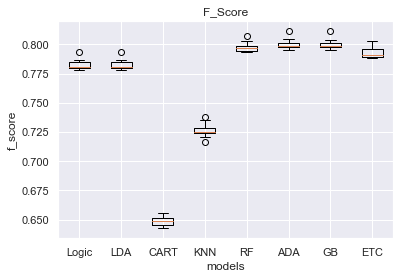

In [175]:
summarize_results(r[3], r[4],'F_Score')

In [176]:
# # Creating pickle file to save models' result from the training Dataset
# with open('model_results1', 'wb') as file:
#     pickle.dump(r, file)

# #Calling the pickle file saved for model results
# with open('model_results1', 'rb') as file:
#     modelResults1 = pickle.load(file)

In [34]:
# Dataframe of test predictions for the base models(8 models)
pred_Ytest = pd.DataFrame(modelResults1[5][0]).T.reset_index()
for i in range(1,8):
    pred = pd.DataFrame(modelResults1[5][i]).T.reset_index()
    pred_Ytest = pd.merge(pred_Ytest, pred, how = 'left', on = 'index')

In [35]:
# Droping index columm, renaming the columns appropriately and adding true y_test
pred_Ytest.drop("index", axis = 1, inplace = True)
pred_Ytest.columns = ['Logic','LDA','CART','KNN', 'RF','ADA', 'GB', 'ETC']
pred_Ytest['Ytest'] = y_test.reset_index(drop=True)
pred_Ytest

,Logic,LDA,CART,KNN,RF,ADA,GB,ETC,Ytest
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
23212,0,0,0,0,0,0,0,0,0
23213,1,1,1,1,1,1,1,1,1
23214,0,0,0,0,0,0,0,0,0
23215,1,1,0,1,1,1,1,1,1


### Plotting Confusion Matrices for test data using the best three(3)  trained models

In [177]:
#Run the first three models to validate their performances and stability on the test data
fmodels = []
fmodels.append(('GradientBoosting', GradientBoostingClassifier()))
fmodels.append(('ADABoost', AdaBoostClassifier()))
fmodels.append(('RandomForest', RandomForestClassifier()))

In [178]:
# Confusion matrix function
def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6)) 

    ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d",
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
    )
    sns.set(font_scale=1)
    plt.title(name)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

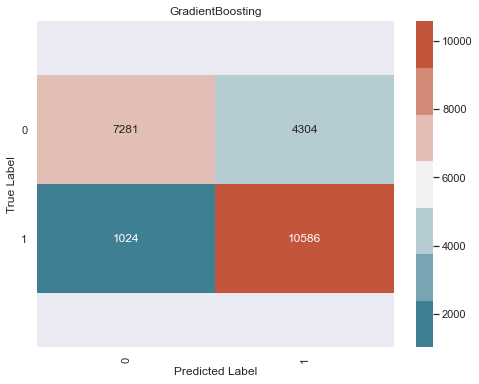



Classification Report:
              precision    recall  f1-score   support

           0   0.876701  0.628485  0.732127     11585
           1   0.710947  0.911800  0.798943     11610

    accuracy                       0.770295     23195
   macro avg   0.793824  0.770143  0.765535     23195
weighted avg   0.793735  0.770295  0.765571     23195



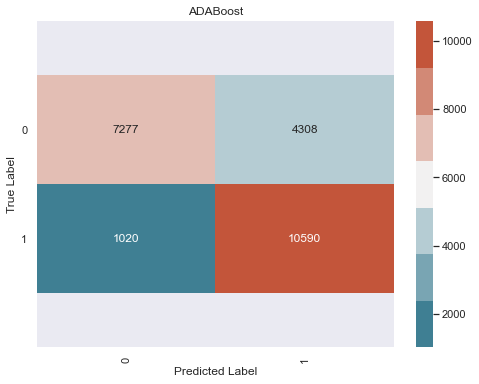



Classification Report:
              precision    recall  f1-score   support

           0   0.877064  0.628140  0.732019     11585
           1   0.710834  0.912145  0.799004     11610

    accuracy                       0.770295     23195
   macro avg   0.793949  0.770142  0.765511     23195
weighted avg   0.793859  0.770295  0.765548     23195



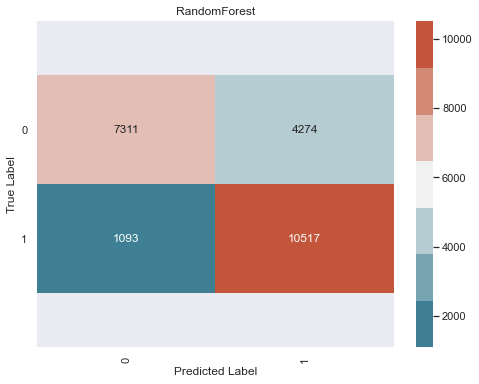



Classification Report:
              precision    recall  f1-score   support

           0   0.869943  0.631075  0.731502     11585
           1   0.711040  0.905857  0.796712     11610

    accuracy                       0.768614     23195
   macro avg   0.790492  0.768466  0.764107     23195
weighted avg   0.790406  0.768614  0.764142     23195



In [179]:
for name, models in fmodels:   
    ##Labeling the target feature classes
    le = preprocessing.LabelEncoder()
    y_test = le.fit_transform(y_test)
    ## Predicting with the best parameter
    model = models.fit(X_train, y_train)
    y_pred = model.predict(X_test) 

    ## plot the confusion matrix
    plot_cm(y_test, y_pred, le.classes_)
    
    ## Print Classification results
    print()
    print()
    print('Classification Report:')
    print('===' * 20)
    #print(classification_report(y_test, y_pred))
    cols = [str(classes) for classes in le.classes_]
    print(classification_report(y_test, y_pred, target_names = cols, digits=6))

## Model Parameter tunning using grid search

In [180]:
#1. Get the GradientBoosting model parameters
GB_model = GradientBoostingClassifier()
GB_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
param_grid = {'ccp_alpha': [0.0],
             'criterion': ['friedman_mse'], 'init': [None],'learning_rate': [0.1,0.3,0.4], 'loss': ['deviance'],
              'max_depth': [3,5,10], 'max_features': [None,'sqrt'], 'max_leaf_nodes':[None], 'min_impurity_decrease': [0.0],
              'min_impurity_split': [None], 'min_samples_leaf': [1], 'min_samples_split': [2,5,10,50], 'min_weight_fraction_leaf':[0.0],
              'n_estimators': [100], 'n_iter_no_change': [None], 'random_state': [10], 'subsample': [1.0, 0.8, 0.7],'tol': [0.0001], 
              'validation_fraction': [0.1], 'verbose': [0],'warm_start': [False, True]
             }
grid = GridSearchCV(GB_model, param_grid = param_grid)
grid.fit(X_train, y_train)

In [50]:
grid.best_params_ 

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 50,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 10,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [181]:
final_modelG = grid.best_estimator_
# final_modelG = GradientBoostingClassifier(min_samples_split=50, random_state=10, subsample=0.8).fit(X_train, y_train)

final_modelG = GradientBoostingClassifier(min_samples_split=50, random_state=10, subsample=0.8).fit(X_train, y_train)

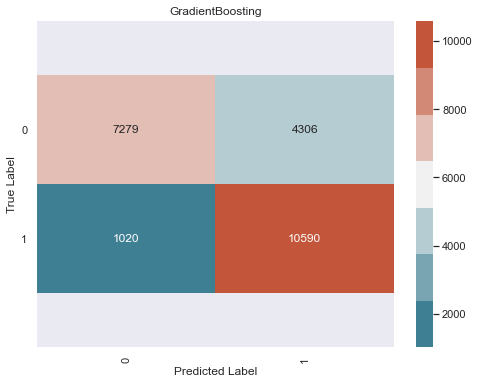



Classification Report:
              precision    recall  f1-score   support

           0   0.877094  0.628312  0.732146     11585
           1   0.710929  0.912145  0.799064     11610

    accuracy                       0.770382     23195
   macro avg   0.794011  0.770229  0.765605     23195
weighted avg   0.793922  0.770382  0.765641     23195



In [182]:
## Labeling the target feature classes
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(y_test)

## Predicting with the best parameter
y_pred = final_modelG.predict(X_test)

## plot the confusion matrix
name = "GradientBoosting" # Title
plot_cm(y_test, y_pred, le.classes_)

print()
print()
print('Classification Report:')
print('===' * 20)
#print(classification_report(y_test, y_pred))

cols = [str(classes) for classes in le.classes_]

print(classification_report(y_test, y_pred, target_names = cols, digits=6))

In [183]:
#2. Get the AdaBoost model parameters 
ADA_model = AdaBoostClassifier()
ADA_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [ ]:
param_grid ={
            'algorithm': ['SAMME.R', 'SAMME'],
            'base_estimator': [None],
            'learning_rate': [0.5, 0.09, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0],
            'n_estimators': [10, 50,60, 80, 100, 500],
            'random_state': [None,10]
            }
grid = GridSearchCV(ADA_model, param_grid = param_grid)
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 0.5,
 'n_estimators': 10,
 'random_state': None}

In [184]:
final_modelA = grid.best_estimator_
# final_modelA = AdaBoostClassifier(learning_rate=0.5, n_estimators=10).fit(X_train, y_train)

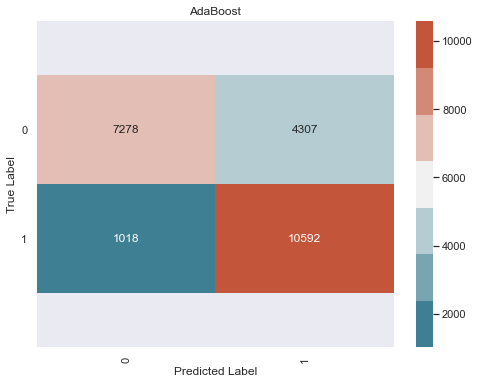



Classification Report:
              precision    recall  f1-score   support

           0   0.877290  0.628226  0.732156     11585
           1   0.710920  0.912317  0.799125     11610

    accuracy                       0.770425     23195
   macro avg   0.794105  0.770272  0.765641     23195
weighted avg   0.794016  0.770425  0.765677     23195



In [185]:
## Labeling the target feature classes
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(y_test)

## Predicting with the best parameter
y_pred = final_modelA.predict(X_test)

## plot the confusion matrix
name = "AdaBoost" #Title
plot_cm(y_test, y_pred, le.classes_)

print()
print()
print('Classification Report:')
print('===' * 20)
#print(classification_report(y_test, y_pred))

cols = [str(classes) for classes in le.classes_]

print(classification_report(y_test, y_pred, target_names = cols, digits=6))

In [ ]:
#3 Get the Random Forest model parameters 
RF_model = RandomForestClassifier()
RF_model.get_params()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num =5 )]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

param_grid

In [ ]:
grid = GridSearchCV(RF_model, param_grid = param_grid)
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

In [ ]:
final_modelR = grid.best_estimator_

In [ ]:
## Labeling the target feature classes
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(y_test)

## Predicting with the best parameter
y_pred = final_modelR.predict(X_test)

## plot the confusion matrix
name = "Random Forest"  #Title
plot_cm(y_test, y_pred, le.classes_)
print()
print()
print('Classification Report:')
print('===' * 20)
#print(classification_report(y_test, y_pred))

cols = [str(classes) for classes in le.classes_]

print(classification_report(y_test, y_pred, target_names = cols, digits=6))

### Predict a new target feature (loan_granted) for the entire dataset using the best model (GBoosting)

In [186]:
##Gradient Boosting Classifier
final_modelG = GradientBoostingClassifier(min_samples_split=50, random_state=10, subsample=0.8).fit(X_train, y_train)
Y_pred = final_modelG.predict(X)

In [187]:
credit_data4["New_loan_granted"] = pd.DataFrame(Y_pred)

In [188]:
## Dropping the initial loan_granted for the newly predicted one
credit_data4 = credit_data4.drop(["loan_granted"], axis = 1)

In [190]:
credit_data4["New_loan_granted"].value_counts()

1    59497
0    33283
Name: New_loan_granted, dtype: int64

* Improved output over the bank model
* More loans are granted

## Creating the required dataset to the modeling loan repaid using the new loan granted feature as one of the features

In [191]:
y2 = credit_data4["loan_repaid"]
x2 = credit_data4.drop(["loan_repaid"], axis = 1)

In [217]:
y2.value_counts()

2    46278
1    30478
0    16024
Name: loan_repaid, dtype: int64

In [192]:
## Identifying important features in the New dataset using Random forest
modelRF = RandomForestClassifier()
modelRF.fit(x2, y2)

FImportance = pd.DataFrame(modelRF.feature_importances_, x2.columns).reset_index()
FImportance.columns =['feature', 'measure']
FImportance= FImportance.sort_values('measure', ascending=False)
FImportance

,feature,measure
3,saving_amount,0.160079
4,checking_amount,0.150615
6,yearly_salary,0.145194
1,TCC_Limit,0.102654
2,Avg_CCL,0.100220
20,New_loan_granted,0.085373
7,age,0.084752
5,is_employed,0.066043
8,dependent_number,0.046260
13,CRO_Loans_1,0.008734


In [193]:
## Variance inflation factor computation
ind_features = x2.copy()
ind_features = add_constant(ind_features).astype(float)

vif = pd.Series([variance_inflation_factor(ind_features.values,i) for i in range(ind_features.shape[1])],
                       index=ind_features.columns, dtype = float)
print('Features Variance inflation factor: \n\n{}\n'.format(vif))

Features Variance inflation factor: 

const                           0.000000e+00
is_first_loan                            inf
TCC_Limit                       1.109852e+00
Avg_CCL                         1.171973e+00
saving_amount                   1.191434e+00
checking_amount                 1.188977e+00
is_employed                     8.886367e+00
yearly_salary                   2.810600e+00
age                             1.002663e+00
dependent_number                1.012849e+00
FRP_Loans_0                     1.627335e+10
FRP_Loans_1                     1.148674e+06
FRP_Loans_2                     2.706303e+10
CRO_Loans_0                     8.754569e+05
CRO_Loans_1                     2.847064e+09
CRO_Loans_2                     1.234484e+10
loan_purpose_business           3.649387e+10
loan_purpose_emergency_funds    4.474337e+10
loan_purpose_home               3.091221e+10
loan_purpose_investment         1.157971e+06
loan_purpose_other              1.426296e+11
New_loan_granted 

In [194]:
## Due to high vif of some features, the less important features are dropped
cols = ['is_employed','FRP_Loans_0', 'FRP_Loans_1', 'FRP_Loans_2', 'CRO_Loans_0', 'CRO_Loans_1', 'CRO_Loans_2', 'loan_purpose_other']
X2 = x2.drop(cols, axis = 1)

* is_employed, FRP_Loans_0, FRP_Loans_1, FRP_Loans_2, CRO_Loans_0, CRO_Loans_1, CRO_Loans_2, and loan_purpose_other were dropped to prevent multicollinearity

In [195]:
## Variance inflation factor computation
ind_features = X2.copy()
ind_features = add_constant(ind_features).astype(float)

vif = pd.Series([variance_inflation_factor(ind_features.values,i) for i in range(ind_features.shape[1])],
                       index=ind_features.columns, dtype = float)
print('Features Variance inflation factor: \n\n{}\n'.format(vif))

Features Variance inflation factor: 

const                           40.475415
is_first_loan                    1.000108
TCC_Limit                        1.104953
Avg_CCL                          1.075708
saving_amount                    1.179598
checking_amount                  1.177924
yearly_salary                    2.331568
age                              1.002618
dependent_number                 1.012455
loan_purpose_business            1.920285
loan_purpose_emergency_funds     1.784201
loan_purpose_home                1.974408
loan_purpose_investment          1.912909
New_loan_granted                 2.314695
dtype: float64



In [196]:
## Creatng the new test and train data for modeling
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size = 0.25, random_state = 20)

In [197]:
print(y2_train.value_counts())
print('*'*20)
print(y2_test.value_counts())

2    34736
1    22759
0    12090
Name: loan_repaid, dtype: int64
********************
2    11542
1     7719
0     3934
Name: loan_repaid, dtype: int64


* The target feature dataset is somewhat imbalanced

In [198]:
## Models to consider
models = []
models.append(('Logic', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ETC', ExtraTreesClassifier()))

In [199]:
##Function to run 8 different models on training data using cross validation and
## y_test was predicted using the models

def model_selection(x_train, y_train, x_test):
    acc_result = []
    #auc_result = []
    names = []
      
    j_scores = list()
    #k_scores = list()
    pred_ytest = list()

    col = ['Model', 'ACC Mean', 'ACC Std'] #, 'AUC Mean', 'AUC Std']
    result = pd.DataFrame(columns = col)

    i=0
    for name, model in models:
        kfold = KFold(n_splits = 10)
        cv_acc_result  = cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'accuracy')
        #cv_auc_result  = cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'roc_auc')
            
        acc_result.append(cv_acc_result)
        #auc_result.append(cv_auc_result)
        names.append(name)
        
        j_scores.append(cv_acc_result)
        #k_scores.append(cv_auc_result)        
        
        result.loc[i] = [name, 
                         cv_acc_result.mean(),
                         cv_acc_result.std()]
                         #cv_auc_result.mean(),
                         #cv_auc_result.std()]
        
        model.fit(x_train, y_train)
        y_pred = [model.predict(x_test)]
        pred_ytest.append(y_pred)
        
        i+= 1
    result = result.sort_values('ACC Mean', ascending = False)
    return result, j_scores, names, pred_ytest   

In [200]:
# Calling and running the models
r = model_selection(X2_train, y2_train, X2_test)
r[0]

,Model,ACC Mean,ACC Std
6,GB,0.730574,0.004057
4,RF,0.727801,0.003609
7,ETC,0.723877,0.003117
1,LDA,0.720802,0.004661
0,Logic,0.716318,0.004231
5,ADA,0.691270,0.022324
3,KNN,0.679083,0.005361
2,CART,0.608220,0.007422


In [201]:
# # Creating pickle file to save models' result from the training Dataset
# with open('model_results2', 'wb') as file:
#     pickle.dump(r, file)

# # Calling the pickle file saved for model results
# with open('model_results2', 'rb') as file:
#     modelResults2 = pickle.load(file)

In [ ]:
# Dataframe of test predictions for the base models(8 models)
pred_Ytest = pd.DataFrame(modelResults2[3][0]).T.reset_index()
for i in range(1,8):
    pred = pd.DataFrame(modelResults2[3][i]).T.reset_index()
    pred_Ytest = pd.merge(pred_Ytest, pred, how = 'left', on = 'index')

In [ ]:
# Droping index columm, renaming the columns appropriately and adding true y_test
pred_Ytest.drop(["index"], axis = 1, inplace = True)
pred_Ytest.columns = ['Logic','LDA','CART','KNN', 'RF','ADA', 'GB', 'ETC']
pred_Ytest['Ytest'] = pd.DataFrame(y2_test).reset_index(drop=True)
pred_Ytest

### Plotting Confusion Matrices for test data using the three(3) best models on the training data

In [202]:
## The best three models to confirm their performances on the test data
models = []
models.append(('GradientBoosting', GradientBoostingClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('ExtraTrees', ExtraTreesClassifier()))

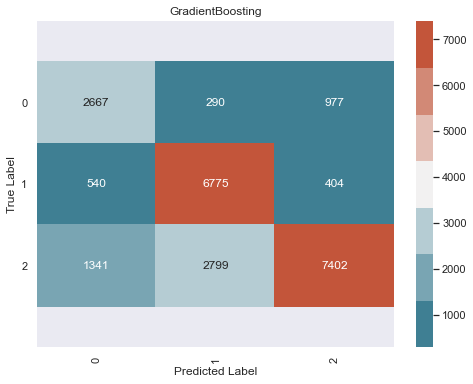



Classification Report:
              precision    recall  f1-score   support

           0   0.586412  0.677936  0.628861      3934
           1   0.686841  0.877704  0.770631      7719
           2   0.842764  0.641310  0.728364     11542

    accuracy                       0.726191     23195
   macro avg   0.705339  0.732317  0.709285     23195
weighted avg   0.747396  0.726191  0.725554     23195



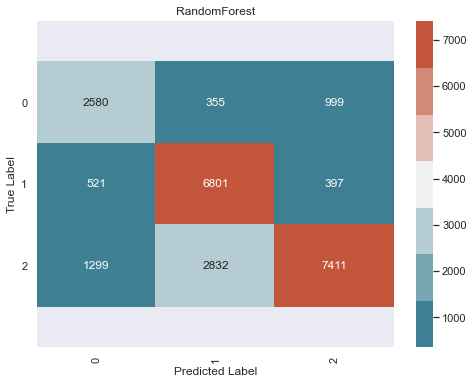



Classification Report:
              precision    recall  f1-score   support

           0   0.586364  0.655821  0.619150      3934
           1   0.680917  0.881073  0.768171      7719
           2   0.841490  0.642090  0.728390     11542

    accuracy                       0.723949     23195
   macro avg   0.702923  0.726328  0.705237     23195
weighted avg   0.744782  0.723949  0.723101     23195



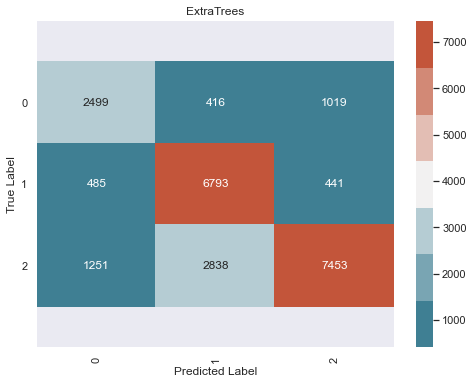



Classification Report:
              precision    recall  f1-score   support

           0   0.590083  0.635231  0.611825      3934
           1   0.676122  0.880036  0.764719      7719
           2   0.836194  0.645729  0.728722     11542

    accuracy                       0.721923     23195
   macro avg   0.700800  0.720332  0.701755     23195
weighted avg   0.741182  0.721923  0.720875     23195



In [203]:
for name, model in models:   
    ##Labeling the target feature classes
    le = preprocessing.LabelEncoder()
    y2_test = le.fit_transform(y2_test)
    
    ## Predicting with the best parameter
    model = model.fit(X2_train, y2_train)
    y2_pred = model.predict(X2_test) 

    ## plot the confusion matrix
    plot_cm(y2_test,
             le.inverse_transform(y2_pred),
             le.classes_)
    
    ## Print Classification results
    print()
    print()
    print('Classification Report:')
    print('===' * 20)
    #print(classification_report(y_test, y_pred))
    cols = [str(classes) for classes in le.classes_]

    print(classification_report(y2_test, y2_pred, target_names = cols, digits=6))

In [218]:
## Model Parameter Tunning
## Get the GradientBoosting model parameters
GB_model = GradientBoostingClassifier()
GB_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [220]:
param_grid = {'ccp_alpha': [0.0],
             'criterion': ['friedman_mse'], 'init': [None],'learning_rate': [0.1,0.3,0.4], 'loss': ['deviance'],
              'max_depth': [3,5,10], 'max_features': [None,'sqrt', 'log2'], 'max_leaf_nodes':[None], 'min_impurity_decrease': [0.0],
              'min_impurity_split': [None], 'min_samples_leaf': [1], 'min_samples_split': [2,5], 'min_weight_fraction_leaf':[0.0],
              'n_estimators': [100], 'n_iter_no_change': [None], 'random_state': [10], 'subsample': [1.0, 0.8],'tol': [0.0001], 
              'validation_fraction': [0.1], 'verbose': [0],'warm_start': [False, True]
             }
grid = GridSearchCV(GB_model, param_grid = param_grid)
grid.fit(X2_train, y2_train)

In [ ]:
grid.best_params_ 

###  Best Parameters
{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 10,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [206]:
final_modelG2 = grid.best_estimator_
#final_modelG2 = GradientBoostingClassifier(max_features = 'sqrt', random_state = 10, subsample= 0.8).fit(X2_train, y2_train)

In [207]:
# # Creating pickle file to save models' result from the training Dataset
# with open('model_param', 'wb') as file:
#     pickle.dump(final_modelG2, file)

# # Calling the pickle file saved for model results
# with open('model_param', 'rb') as file:
#     modelParam = pickle.load(file)

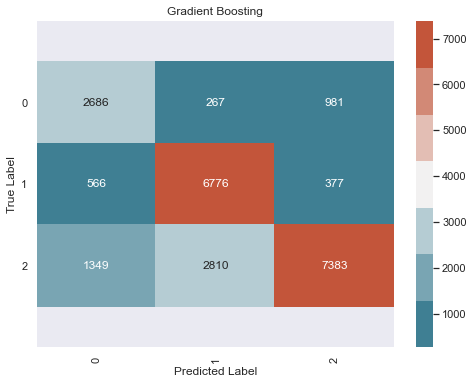



Classification Report:
              precision    recall  f1-score   support

           0   0.583786  0.682766  0.629408      3934
           1   0.687709  0.877834  0.771227      7719
           2   0.844640  0.639664  0.727999     11542

    accuracy                       0.726234     23195
   macro avg   0.705379  0.733421  0.709545     23195
weighted avg   0.748173  0.726234  0.725663     23195



In [208]:
## Labeling the target feature classes
le = preprocessing.LabelEncoder()
y2_test = le.fit_transform(y2_test)

## Predicting with the best parameter
name = "Gradient Boosting"
y2_pred = modelParam.predict(X2_test)

## plot the confusion matrix
plot_cm(y2_test, y2_pred, le.classes_)
print()
print()
print('Classification Report:')
print('===' * 20)
#print(classification_report(y_test, y_pred))

cols = [str(classes) for classes in le.classes_]

print(classification_report(y2_test, y2_pred, target_names = cols, digits=6))

### Predicting the new target feature for the dataset using the best parameter for Gradient Boosting model to compare the performance of the model to the bank's model

In [209]:
model = GradientBoostingClassifier(max_features = 'sqrt', random_state = 10, subsample = 0.8).fit(X2, y2)
credit_data4['New_loan_repaid'] = model.predict(X2)

In [210]:
credit_data4.head()

,is_first_loan,TCC_Limit,Avg_CCL,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_repaid,FRP_Loans_0,FRP_Loans_1,FRP_Loans_2,CRO_Loans_0,CRO_Loans_1,CRO_Loans_2,loan_purpose_business,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other,New_loan_granted,New_loan_repaid
0,1,0.576923,0.449541,0.308712,0.077161,0,0.000000,0.475410,0.375,2,0,0,1,0,0,1,1,0,0,0,0,0,2
1,0,0.307692,0.944954,0.059769,0.381059,1,0.138889,0.245902,0.125,2,0,1,0,1,0,0,0,0,0,1,0,0,2
2,1,0.492308,0.752294,0.195940,0.246081,1,0.252058,0.327869,1.000,1,0,0,1,0,0,1,0,0,0,0,1,1,1
3,0,0.053846,0.752294,0.033643,0.243636,0,0.000000,0.098361,0.125,2,0,1,0,1,0,0,0,0,0,1,0,0,2
4,0,0.492308,0.733945,0.200921,0.307925,1,0.186214,0.295082,0.125,2,1,0,0,1,0,0,0,1,0,0,0,1,1


In [216]:
credit_data4["New_loan_repaid"].value_counts()

1    39529
2    34488
0    18763
Name: New_loan_repaid, dtype: int64

In [211]:
## Creating new dataframe to confirm the profitability of the model with the Bank model
repayment_score = credit_data4[["loan_repaid", "New_loan_repaid"]]

In [212]:
repayment_score["loan_repaid_score"] = repayment_score["loan_repaid"]
repayment_score["New_loan_repaid_score"] = repayment_score["New_loan_repaid"]
repayment_score["loan_repaid_score"] = repayment_score["loan_repaid_score"].astype("str").astype(int)

In [213]:
cols = ["loan_repaid_score", "New_loan_repaid_score"]
for col in cols:
    repayment_score[col].replace([0,1,2], [-1,1,0], inplace=True)

In [214]:
repayment_score.head(20)

,loan_repaid,New_loan_repaid,loan_repaid_score,New_loan_repaid_score
0,2,2,0,0
1,2,2,0,0
2,1,1,1,1
3,2,2,0,0
4,2,1,0,1
5,1,1,1,1
6,2,2,0,0
7,0,0,-1,-1
8,1,1,1,1
9,1,0,1,-1


In [215]:
print(repayment_score["New_loan_repaid_score"].sum())
print(repayment_score["loan_repaid_score"].sum())

20766
14454


In [ ]:
### END ###